In [23]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import helper

In [24]:

training = "traffic-signs-data/train.p"
testing = "traffic-signs-data/test.p"


with open(training, mode='rb') as file:
    train = pickle.load(file) 

with open(testing, mode='rb') as file:
    test = pickle.load(file)

In [37]:
X_tr, Y_tr = train['features'], train['labels']
X_te, Y_te = test['features'], test['labels']

classes = len(set(Y_tr))


print ("Training iputs shape: {}".format(X_tr.shape))
print ("Training labels shape: {}".format(Y_tr.shape))

print ("Testing iputs shape: {}".format(X_te.shape))
print ("Testing labels shape: {}".format(Y_te.shape))
print ("Number of classes {}". format(classes))

Training iputs shape: (39209, 32, 32, 3)
Training labels shape: (39209,)
Testing iputs shape: (12630, 32, 32, 3)
Testing labels shape: (12630,)
Number of classes 43


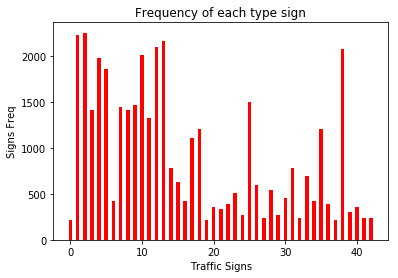

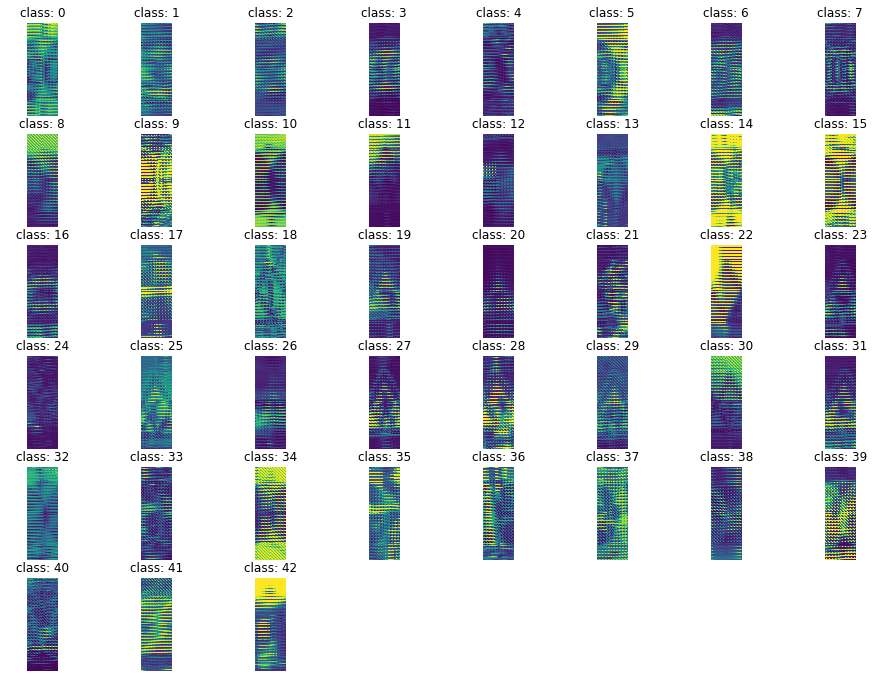

In [46]:
import random as rd

fig, ax = plt.subplots()
ax.bar(range(classes), np.bincount(Y_tr), 0.5, color='r')
ax.set_xlabel('Traffic Signs')
ax.set_ylabel('Signs Freq')
ax.set_title('Frequency of each type sign')
plt.show()

plt.figure(figsize=(16, 16))
for i in range(classes):
    j = rd.choice(np.where(Y_tr == i)[0])
    plt.subplot(8, 8, i + 1)
    plt.axis('off')
    plt.title('class: {}'.format(i))
    plt.imshow(X_tr[j])

In [54]:
tf.reset_default_graph()
sess = tf.Session()
l = len(X_tr)
X_tr = np.reshape(X_tr, (l, 96, 32))
X_te = np.reshape(X_te, (-1, 96, 32))

print(X_tr.shape)
print(X_te.shape)

(39209, 96, 32)
(12630, 96, 32)


In [55]:
def stats(X_batch, Y_batch):
    total_loss = 0
    total_acc = 0
    samples = len(X_batch)
    #X_batch = np.reshape(X_batch, [-1, n_steps, n_inputs])
    sess = tf.get_default_session()
    for offset in range(0, samples, batch_size):
        end = offset+batch_size
        xs_batch, ys_batch = X_batch[offset:end], Y_batch[offset:end]
        loss_, acc = sess.run([loss, accuracy], feed_dict={x:xs_batch, 
                                                           y:ys_batch,
                                                           keep_prob:1.0})
        total_loss += (float(loss_)*xs_batch.shape[0])
        total_acc += (float(acc)*xs_batch.shape[0])

    return (total_loss)/samples, (total_acc)/samples

In [56]:

def RNN(x_, w, b):
    x_ = tf.transpose(x_, [1, 0, 2])
    x_ = tf.reshape(x_, [-1, n_inputs])
    
    
    hidden = tf.matmul(x_, w['hidden']) + b['hidden']
    hidden = tf.nn.relu(hidden)
    hidden = tf.split(hidden, n_steps, 0)
    rnn_layers = [tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.GRUCell(n_hidden), output_keep_prob=keep_prob) for _ in range(n_layers)]
    rnn_layers = tf.contrib.rnn.MultiRNNCell(rnn_layers)
    outputs, _ = tf.contrib.rnn.static_rnn(rnn_layers, hidden, dtype=tf.float32)
    
    rnn_output = outputs[-1]
    return tf.matmul(rnn_output, w['out']) + b['out']
    
    
    

In [57]:
learning_rate = 1e-3
n_steps = 96 
n_inputs = 32

n_layers = 2
n_hidden = 128
n_classes = classes
batch_size = 128

w = {
    'hidden': tf.Variable(tf.random_normal([n_inputs, n_hidden])),
    'out'   : tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
b = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out'  : tf.Variable(tf.random_normal([n_classes]))
}


x = tf.placeholder(dtype=tf.float32, shape=[None, n_steps, n_inputs], name='x')
y = tf.placeholder(dtype=tf.int32, shape=[None], name='y')
keep_prob = tf.placeholder(dtype=tf.float32)
y_hot = tf.one_hot(y, classes, name='one_hot')
#keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')


In [58]:
logits = RNN(x, w, b)

In [59]:
softmax = tf.nn.softmax(logits, name='logits')

step = tf.Variable(0, trainable=False)
with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_hot))
with tf.name_scope("train_step"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='optimizer').minimize(loss)

prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_hot, 1))
accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))

In [60]:
init = tf.global_variables_initializer()
sess.run(init)

In [61]:

from sklearn.utils import shuffle

train_loss = []
train_acc = []
val_loss = []
val_acc = []
test_loss_ = []
test_acc_ = []
epochs = 1000
samples = len(X_tr)

count = 0
print("Initializing Training")
try:
    for epoch in range(epochs):
        X_tr, Y_tr = shuffle(X_tr, Y_tr)
        for offset in range(0, samples, batch_size):
            end = offset+batch_size
                
                
            xs_batch, ys_batch = X_tr[offset:end], Y_tr[offset:end]
            #xs_batch = np.reshape(xs_batch, (batch_size, n_steps, n_inputs))
            loss_, _, acc_ = sess.run([loss, optimizer, accuracy], feed_dict={x: xs_batch, 
                                                                              y: ys_batch,
                                                                              keep_prob: 0.8})    
            if count % 100 == 0:
                print('Epoch {} Loss = {} and Accuracy {}'.format(epoch, loss_, 100 * acc_))

            train_loss.append(loss_)
            train_acc.append(acc_)
            count += 1
        #validation_loss, validation_acc = stats(X_tr, Y_tr)
        #if epoch % 10 == 0:
            
        #val_loss.append(validation_loss)
        #val_acc.append(validation_acc)
        #print("EPOCH {}".format(epoch + 1))
        #print ("Validation Loss = {:.3f} and Validation Accuracy = {:.3f} %".format(validation_loss, 100 *validation_acc))
    test_loss, test_acc = train(X_te, Y_te)
    test_loss_.append(test_loss)
    test_acc_.append(test_acc)
    print ("Test Loss {} and Test Accuracy {:.3f} %".format(test_loss, 100 *test_acc))
except KeyboardInterrupt:
    print('Training interrupted')

Initializing Training


ResourceExhaustedError: OOM when allocating tensor with shape[128,128]
	 [[Node: rnn/rnn/multi_rnn_cell/cell_0/cell_0/gru_cell/candidate_26/mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](rnn/rnn/multi_rnn_cell/cell_0/cell_0/gru_cell/gates_26/split, rnn/rnn/multi_rnn_cell/cell_0/cell_0/gru_cell/add_25)]]
	 [[Node: Mean/_21 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_49830_Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'rnn/rnn/multi_rnn_cell/cell_0/cell_0/gru_cell/candidate_26/mul', defined at:
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-58-d12786eecf56>", line 1, in <module>
    logits = RNN(x, w, b)
  File "<ipython-input-56-465791ec8f79>", line 12, in RNN
    outputs, _ = tf.contrib.rnn.static_rnn(rnn_layers, hidden, dtype=tf.float32)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py", line 1212, in static_rnn
    (output, state) = call_cell()
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py", line 1199, in <lambda>
    call_cell = lambda: cell(input_, state)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/rnn_cell_impl.py", line 180, in __call__
    return super(RNNCell, self).__call__(inputs, state)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 441, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/rnn_cell_impl.py", line 916, in call
    cur_inp, new_state = cell(cur_inp, cur_state)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/rnn_cell_impl.py", line 752, in __call__
    output, new_state = self._cell(inputs, state, scope)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/rnn_cell_impl.py", line 180, in __call__
    return super(RNNCell, self).__call__(inputs, state)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 441, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/rnn_cell_impl.py", line 299, in call
    _linear([inputs, r * state], self._num_units, True,
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 838, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1061, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1377, in _mul
    result = _op_def_lib.apply_op("Mul", x=x, y=y, name=name)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/cesar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[128,128]
	 [[Node: rnn/rnn/multi_rnn_cell/cell_0/cell_0/gru_cell/candidate_26/mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](rnn/rnn/multi_rnn_cell/cell_0/cell_0/gru_cell/gates_26/split, rnn/rnn/multi_rnn_cell/cell_0/cell_0/gru_cell/add_25)]]
	 [[Node: Mean/_21 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_49830_Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
